In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import torchvision
from torchvision.transforms import transforms

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
DATA_DIR = "/content/gdrive/Shared drives/CS523/archive"

Mounted at /content/gdrive


In [ ]:
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['frame_id', 'png_image_path', 'png_mask_path']]
metadata_df['png_image_path'] = metadata_df['png_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['png_mask_path'] = metadata_df['png_mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
test_df = valid_df.sample(frac=0.5,random_state=42)
valid_df = valid_df.drop(test_df.index)
len(train_df), len(valid_df), len(test_df)

(551, 31, 30)

In [ ]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
0# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'polyp']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    # x = 1.0 *(image>0)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [ ]:
class EndoscopyDataset(torch.utils.data.Dataset):

    """CVC-ClinicDB Endoscopic Colonoscopy Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:    
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['png_image_path'].tolist()
        self.mask_paths = df['png_mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]),cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            state = torch.get_rng_state()
            image = self.augmentation(image)
            torch.set_rng_state(state)
            mask = self.augmentation(mask.astype(np.uint8))
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [ ]:
transformer = transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(p=.5),
                                  transforms.RandomVerticalFlip(p=.5),
                                  transforms.RandomRotation([0, 180]),
])

In [ ]:
test_dataset = EndoscopyDataset(test_df, class_rgb_values=select_class_rgb_values)
valid_dataset =  EndoscopyDataset(valid_df, class_rgb_values=select_class_rgb_values)
train_dataset = EndoscopyDataset(train_df, class_rgb_values = select_class_rgb_values)

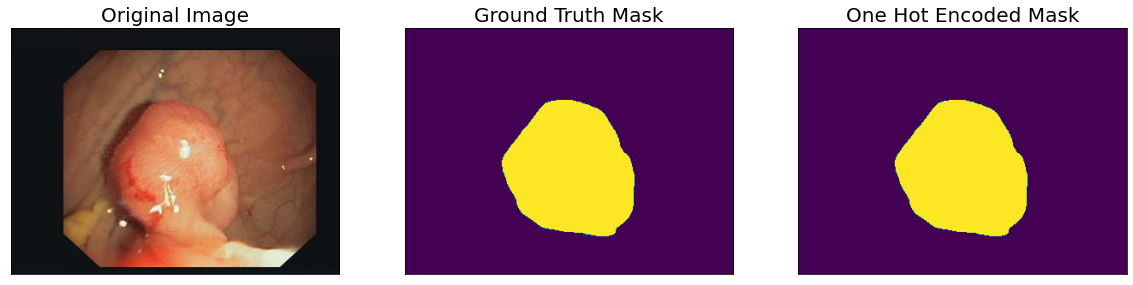

In [ ]:
dataset = EndoscopyDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]
visualize(
    original_image = image,
    ground_truth_mask = reverse_one_hot(mask),
    one_hot_encoded_mask = reverse_one_hot(mask))

In [ ]:
import torch
import torch.nn as nn
import copy
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')

In [ ]:
class double_conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.doubleconv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3, stride=1,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True))
    
  def forward(self,x):
    return self.doubleconv(x)

In [ ]:
class up_conv(nn.Module):
  def __init__(self,in_channels, out_channels):
    super().__init__()
    self.upconv = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2, stride=2)

  def forward(self, x, skip):
    x = self.upconv(x)
    x = torch.cat([x,skip],1) #does order matter?
    return x

In [ ]:
class Unet(nn.Module):
  def __init__(self, channels, classes):
    super().__init__()
    self.channels = channels
    self.classes = classes

    self.double1 = double_conv(channels, 64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double2 = double_conv(64, 128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double3 = double_conv(128,256)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double4 = double_conv(256, 512)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.double5 = double_conv(512,1024)

    # Up
    self.up1 = up_conv(1024,512)
    self.updouble1 = double_conv(1024,512)
    self.up2 = up_conv(512,256)
    self.updouble2 = double_conv(512,256)
    self.up3 = up_conv(256,128)
    self.updouble3 = double_conv(256,128)
    self.up4 = up_conv(128,64)
    self.updouble4 = double_conv(128,64)

    # last convolution
    self.lastconv = nn.Conv2d(64,classes,1)

  def forward(self, x):
    d1 = self.double1(x)
    d2 = self.double2(self.pool1(d1))
    d3 = self.double3(self.pool2(d2))
    d4 = self.double4(self.pool3(d3))
    d5 = self.double5(self.pool4(d4))
    # up bit - theres some concatenation involved. 
    u1_up = self.up1(d5,d4)
    u1 = self.updouble1(u1_up)
    u2 = self.updouble2(self.up2(u1,d3))
    u3 = self.updouble3(self.up3(u2,d2))
    u4 = self.updouble4(self.up4(u3,d1))
    u_final = self.lastconv(u4)

    return u_final

In [ ]:
model = Unet(3,2)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
lr_set = 3e-5
optimizer = torch.optim.NAdam(model.parameters(),lr = lr_set)

cuda:0


In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [ ]:
def reverse_to_tensor(x, **kwargs):
  return x.transpose(1,2,0).astype('float32')

In [ ]:
from tqdm import tqdm

In [ ]:
epochs = 40
from sklearn.metrics import jaccard_score
train_losses = []
val_losses =[]
for epoch in range(epochs):  # loop over the dataset multiple times
    val_loss = 0.0
    train_loss = 0.0
    for i, data in tqdm(enumerate(train_dataset, 0), total = len(train_dataset), desc= "training"):
        ## -- ! code required
        # print(np.asarray(data[0]).shape)
        # print(reverse_to_tensor(to_tensor(np.asarray(data[0]))).shape)
        images = torch.from_numpy(to_tensor(np.asarray(data[0]))).float()
        mask = torch.from_numpy(to_tensor(np.asarray(data[1]))).float()
        images= images.unsqueeze(0).to(device)
        # print(images.shape)
        mask = mask.unsqueeze(0).to(device)
        # print(mask.shape)
        optimizer.zero_grad()
        # forward + backward + optimize
        out = model.forward(images)
        loss = criterion(out,mask)
        loss.backward(retain_graph=True)
        optimizer.step()
        # print statistics
        train_loss += loss.item()    

    with torch.no_grad():
		# set the model in evaluation mode
      model.eval()
		# loop over the validation set
      for j,vdata in tqdm(enumerate(valid_dataset, 0), total = len(test_dataset), desc= "validation"):
			# send the input to the device
        vimages = torch.from_numpy(to_tensor(np.asarray(vdata[0]))).float()
        vmask = torch.from_numpy(to_tensor(np.asarray(vdata[1]))).float()
        vimages= vimages.unsqueeze(0).to(device)
        vmask = vmask.unsqueeze(0).to(device)
			# make the predictions and calculate the validation loss
        
        pred = model(vimages)
        vloss = criterion(pred,vmask)
        val_loss += vloss.item()
    
    avg_train_loss = train_loss/len(train_dataset)
    avg_val_loss = val_loss/len(test_dataset)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print('epoch %d training loss: %.3f, validation loss: %.3f /' %(epoch + 1, avg_train_loss, avg_val_loss))


print('Finished Training')

training: 100%|██████████| 551/551 [08:29<00:00,  1.08it/s]
validation: 31it [00:19,  1.56it/s]


epoch 1 training loss: 0.559, validation loss: 0.468 /


training: 100%|██████████| 551/551 [03:52<00:00,  2.37it/s]
validation: 31it [00:05,  5.51it/s]


epoch 2 training loss: 0.227, validation loss: 0.226 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.50it/s]


epoch 3 training loss: 0.205, validation loss: 0.213 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.58it/s]


epoch 4 training loss: 0.191, validation loss: 0.205 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.48it/s]


epoch 5 training loss: 0.174, validation loss: 0.169 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.53it/s]


epoch 6 training loss: 0.156, validation loss: 0.154 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.51it/s]


epoch 7 training loss: 0.140, validation loss: 0.137 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.56it/s]


epoch 8 training loss: 0.120, validation loss: 0.134 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.43it/s]


epoch 9 training loss: 0.105, validation loss: 0.128 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.62it/s]


epoch 10 training loss: 0.091, validation loss: 0.122 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.50it/s]


epoch 11 training loss: 0.080, validation loss: 0.117 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.55it/s]


epoch 12 training loss: 0.075, validation loss: 0.091 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.49it/s]


epoch 13 training loss: 0.064, validation loss: 0.089 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.57it/s]


epoch 14 training loss: 0.053, validation loss: 0.090 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.46it/s]


epoch 15 training loss: 0.061, validation loss: 0.098 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.60it/s]


epoch 16 training loss: 0.051, validation loss: 0.085 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.43it/s]


epoch 17 training loss: 0.040, validation loss: 0.093 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.56it/s]


epoch 18 training loss: 0.031, validation loss: 0.095 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.39it/s]
validation: 31it [00:05,  5.49it/s]


epoch 19 training loss: 0.031, validation loss: 0.086 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.59it/s]


epoch 20 training loss: 0.053, validation loss: 0.086 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.49it/s]


epoch 21 training loss: 0.031, validation loss: 0.089 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.57it/s]


epoch 22 training loss: 0.024, validation loss: 0.130 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.46it/s]


epoch 23 training loss: 0.030, validation loss: 0.079 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.64it/s]


epoch 24 training loss: 0.034, validation loss: 0.094 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.49it/s]


epoch 25 training loss: 0.027, validation loss: 0.113 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.56it/s]


epoch 26 training loss: 0.026, validation loss: 0.102 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.48it/s]


epoch 27 training loss: 0.033, validation loss: 0.082 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.58it/s]


epoch 28 training loss: 0.022, validation loss: 0.100 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.52it/s]


epoch 29 training loss: 0.015, validation loss: 0.115 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.60it/s]


epoch 30 training loss: 0.015, validation loss: 0.115 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.50it/s]


epoch 31 training loss: 0.046, validation loss: 0.089 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.59it/s]


epoch 32 training loss: 0.018, validation loss: 0.093 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.50it/s]


epoch 33 training loss: 0.013, validation loss: 0.105 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.56it/s]


epoch 34 training loss: 0.012, validation loss: 0.099 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.50it/s]


epoch 35 training loss: 0.010, validation loss: 0.119 /


training: 100%|██████████| 551/551 [03:51<00:00,  2.38it/s]
validation: 31it [00:05,  5.59it/s]


epoch 36 training loss: 0.013, validation loss: 0.141 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.48it/s]


epoch 37 training loss: 0.043, validation loss: 0.124 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.59it/s]


epoch 38 training loss: 0.016, validation loss: 0.107 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.48it/s]


epoch 39 training loss: 0.021, validation loss: 0.100 /


training: 100%|██████████| 551/551 [03:50<00:00,  2.39it/s]
validation: 31it [00:05,  5.56it/s]

epoch 40 training loss: 0.011, validation loss: 0.102 /
Finished Training


In [ ]:
torch.save(model,'/content/gdrive/Shared drives/CS523/40epochsmodel_NoDataAugmentation.h5')

Text(0, 0.5, 'loss value')

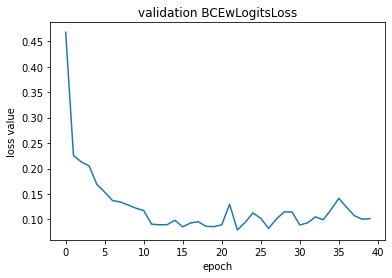

In [ ]:
plt.plot(val_losses)
plt.title('validation BCEwLogitsLoss')
plt.xlabel('epoch')
plt.ylabel('loss value')
# plt.savefig("val losses %d epochs, lr %d",(10,0.001))

Text(0, 0.5, 'loss value')

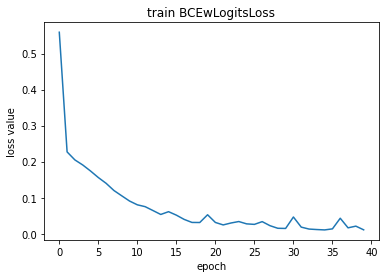

In [ ]:
plt.plot(train_losses)
plt.title('train BCEwLogitsLoss')
plt.xlabel('epoch')
plt.ylabel('loss value')

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
loaded_model = torch.load('/content/gdrive/Shared drives/CS523/40epochsmodel_NoDataAugmentation.h5')

In [ ]:
# # model predictions

# for i in range(len(test_dataset)) :
#     image, mask = test_dataset[i]
#     x = torch.from_numpy(image).unsqueeze(0)
#     pred_mask = loaded_model(x)
#     pred_mask = np.transpose(pred_mask,(1,2,0))
#     pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

#     # ground truth mask
#     mask = np.transpose(mask,(1,2,0))
#     mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
    
#     visualize (
#         original_image = image,
#         ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
#         one_hot_encoded_mask = reverse_one_hot(mask)
#     )

torch.Size([1, 3, 288, 384])
(2, 288, 384)
(288, 384, 2)
(288, 384)


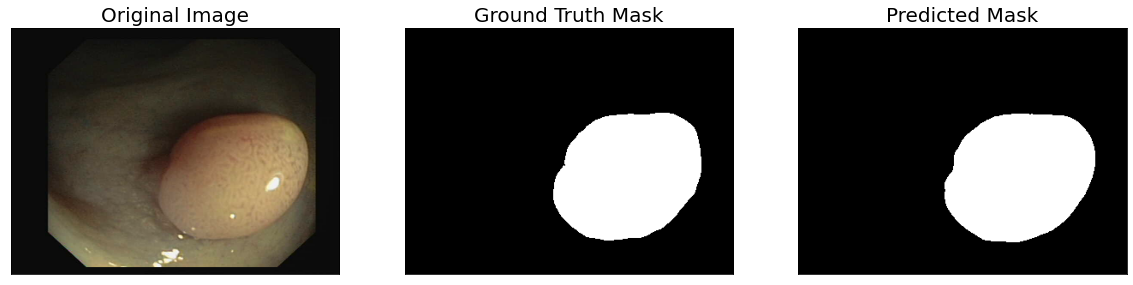

In [ ]:
image, mask = test_dataset[20]
images = torch.from_numpy(to_tensor(image)).float()
images = images.unsqueeze(0).to(device)
print(images.shape)
pred_mask = loaded_model(images)
aaa = pred_mask.cpu().detach().squeeze(0).numpy()
print(aaa.shape)
bbb = reverse_to_tensor(aaa)
print(bbb.shape)
ccc = reverse_one_hot(bbb)
print(ccc.shape)
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    predicted_mask = colour_code_segmentation(ccc, select_class_rgb_values)
)

In [ ]:
    #  intersection = np.diag(self.confusionMatrix)  #  Take the value of the diagonal element , Returns a list of 
    #     union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(
    #         self.confusionMatrix)  # axis = 1 Represents the value of the confusion matrix row , Returns a list of ; axis = 0 Means to take the value of the confusion matrix column , Returns a list of 
    #     IoU = intersection / union  #  Returns a list of , Its value is... Of each category IoU
    #     return IoU]

In [ ]:


# cf_matrix = confusion_matrix(pred_mask, mask)
# intersection = np.diag(self.confusionMatrix)  #  Take the value of the diagonal element , Returns a list of 
# union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(cf_matrix)  # axis = 1 Represents the value of the confusion matrix row , Returns a list of ; axis = 0 Means to take the value of the confusion matrix column , Returns a list of 
# IoU = intersection / union  #  Returns a list of , Its value is... Of each category IoU
# return IoU

In [ ]:
from sklearn.metrics import jaccard_score
jaccard = 0;
jacard_list=[];
for i in range(len(test_dataset)):
  image, mask = test_dataset[i]
  images = torch.from_numpy(to_tensor(image)).float()
  images = images.unsqueeze(0).to(device)
  pred_mask = loaded_model(images)
  mask_new = reverse_one_hot(mask.astype(np.int64))
  mask_new = np.int64(mask_new)
  # print(np.unique(mask_new))
  # print(mask_new.dtype)
  pred_mask_new = reverse_one_hot(pred_mask.cpu().detach().numpy().squeeze(0).transpose(1,2,0))
  # print(np.unique(pred_mask_new)/)
  aaa = jaccard_score(mask_new.flatten(),pred_mask_new.flatten())
  jacard_list.append(aaa)
  jaccard += aaa
jaccard /= len(test_dataset)
print(jaccard)

0.8008360624059799


In [ ]:
S = 2*jaccard/(1+jaccard)
print(S)

0.8894047371930514


Text(0, 0.5, 'Index')

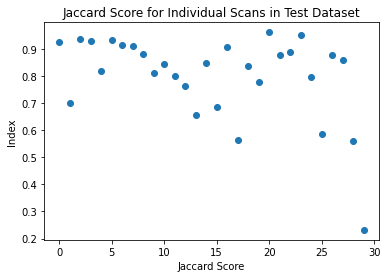

In [ ]:
x = []
for i in range(len(test_dataset)):
  x.append(i)
plt.scatter(x,jacard_list)
plt.title('Jaccard Score for Individual Scans in Test Dataset')
plt.xlabel('Jaccard Score')
plt.ylabel('Index')